<a href="https://colab.research.google.com/github/Jorgecardetegit/NLP/blob/main/Named_Entity_Recognition_with_HuggingFace_%F0%9F%A4%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Named Entity Recognition**

### **Problem Understanding**

Named Entity Recognition (NER) is a sub-task of Information Extraction that classifies named entities into predefined categories such as the names of persons, organizations, locations, expressions of times, quantities, monetary values, percentages, etc.

The primary purpose of NER is to locate and classify named entities mentioned in unstructured text into pre-defined categories like person names, organizations, locations, medical codes, time expressions, quantities, monetary values, percentages, etc.

NER is used in various natural language processing applications including but not limited to:
- Information Retrieval
- Machine Translation
- Question Answering
- Coreference Resolution
- Relation Extraction
- Event Extraction
- Sentiment Analysis

### **Dataset (conll2003)**
The data will be extracted from the famous HuggingFace dataset **Conll2003**.

The shared task of CoNLL-2003 concerns language-independent named entity recognition. It concentrates on four types of named entities: persons, locations, organizations and names of miscellaneous entities that do not belong to the previous three groups.

The dataset contain four columns separated by a single space. Each word has been put on a separate line and there is an empty line after each sentence.

- The first item on each line is a word.

- The second a part-of-speech (POS) tag.

- The third a syntactic chunk tag.

- The fourth the named entity tag.

The chunk tags and the named entity tags have the format **I-TYPE** which means that the word is inside a phrase of type TYPE. Only if two phrases of the same type immediately follow each other, the first word of the second phrase will have tag **B-TYPE** to show that it starts a new phrase. A word with tag **O** is not part of a phrase.

In this analysis we will only focus on the fourth column (ner_tags).

#### **ner_tags example**

My cousin Alexander likes Manhattan.

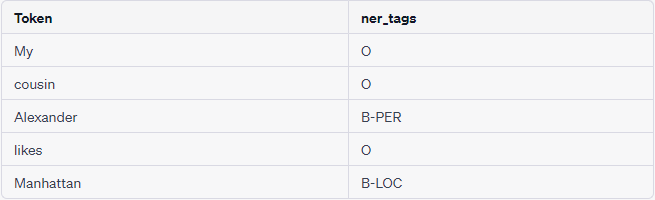

My cousing Alex ander likes Manha ttan.

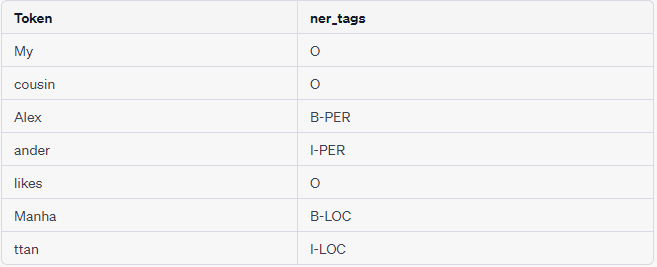


# 1. Libraries and installing dependencies

In [ ]:
import importlib.util

# Function to check if a library is installed
def is_library_installed(name):
    spec = importlib.util.find_spec(name)
    return spec is not None

# Check if both 'transformers' and 'datasets' are installed
if not is_library_installed('transformers') or not is_library_installed('datasets') or not is_library_installed('seqeval') or not is_library_installed('evaluate'):
    !pip install transformers datasets evaluate seqeval

In [11]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import evaluate
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization,Dropout,Input,LayerNormalization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from datasets import load_dataset
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,DataCollatorForTokenClassification,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer,TFRobertaForTokenClassification,TFAutoModelForTokenClassification,)


# 2. Loading dataset

In [ ]:
dataset_id = "conll2003"
dataset = load_dataset(dataset_id)

# 3. Basic EDA

In [20]:
print(dataset)
print(f"\nStructure of the train dataset: {type(dataset['train'])}")

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

Structure of the train dataset: <class 'datasets.arrow_dataset.Dataset'>


In [21]:
for line in dataset['train'].select([0, 1, 2, 3, 4]):
  print(line)

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}
{'id': '1', 'tokens': ['Peter', 'Blackburn'], 'pos_tags': [22, 22], 'chunk_tags': [11, 12], 'ner_tags': [1, 2]}
{'id': '2', 'tokens': ['BRUSSELS', '1996-08-22'], 'pos_tags': [22, 11], 'chunk_tags': [11, 12], 'ner_tags': [5, 0]}
{'id': '3', 'tokens': ['The', 'European', 'Commission', 'said', 'on', 'Thursday', 'it', 'disagreed', 'with', 'German', 'advice', 'to', 'consumers', 'to', 'shun', 'British', 'lamb', 'until', 'scientists', 'determine', 'whether', 'mad', 'cow', 'disease', 'can', 'be', 'transmitted', 'to', 'sheep', '.'], 'pos_tags': [12, 22, 22, 38, 15, 22, 28, 38, 15, 16, 21, 35, 24, 35, 37, 16, 21, 15, 24, 41, 15, 16, 21, 21, 20, 37, 40, 35, 21, 7], 'chunk_tags': [11, 12, 12, 21, 13, 11, 11, 21, 13, 11, 12, 13, 11, 21, 22, 11, 12, 17, 11, 21, 1

The token column already has a type of preprocessing as the words are separated. Is important to take this into account, when we apply the tokenizer to the dataset we will have to specify that the senteces are already splitted.

# 4. Preprocessing

### Tokenizer

In [22]:
model_id="roberta-base"
tokenizer=RobertaTokenizerFast.from_pretrained(model_id,add_prefix_space=True)

In [31]:
inputs = tokenizer(dataset["train"][0]["tokens"], is_split_into_words=True,)

print(f"Orginial input: {dataset['train']['tokens'][0]}\n")
print(f"Post tokenizer input: {inputs.tokens()}")

Orginial input: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

Post tokenizer input: ['<s>', 'ĠEU', 'Ġrejects', 'ĠGerman', 'Ġcall', 'Ġto', 'Ġboycott', 'ĠBritish', 'Ġlamb', 'Ġ.', '</s>']


### Tokenizer explanation

- The **\<s>** and **\</s>** tokens are special tokens representing the beginning and end of the sentence, respectively.

- The **'Ġ'** character represents a space before each word.

- The actual words from the original input follow the **'Ġ'** character.

The **"Ġ"** character you see at the beginning of some tokens is a special character used by some tokenizers, including the tokenizer used in OpenAI's GPT (Generative Pre-trained Transformer) models. This character represents a space, and it helps the model to differentiate between spaces that occur at the beginning of a word and spaces that occur elsewhere.

### Aligment of labels with tokens

Once the dataset is preprocessed and tokenized, is important to allign the labels with the tokens. Rembemer that the ner_tags column has the following cofinguration:

{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

In [32]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [33]:
def tokenizer_function(dataset):
  out=tokenizer(dataset["tokens"],truncation=True,is_split_into_words=True,)
  out['labels']=align_labels_with_tokens(dataset["ner_tags"],out.word_ids())
  return out

tokenized_dataset=dataset.map(tokenizer_function,remove_columns=['id','tokens','pos_tags','chunk_tags','ner_tags',])

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [37]:
tokenized_dataset

tokenized_dataset["train"][0]

{'input_ids': [0, 1281, 24020, 1859, 486, 7, 13978, 1089, 17988, 479, 2],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, -100]}

# 5. Preparing the model

In [38]:
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer, return_tensors="tf"
)

In [41]:
BATCH_SIZE = 16

tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    collate_fn=data_collator,
    shuffle=True,
    batch_size=BATCH_SIZE,
)

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [42]:
tf_val_dataset = tokenized_dataset["validation"].to_tf_dataset(
    collate_fn=data_collator,
    shuffle=False,
    batch_size=BATCH_SIZE,
)

# 6. Model architecture

### TFRobertaForSequenceClassification

In [43]:
model=TFRobertaForTokenClassification.from_pretrained(
    model_id,
    num_labels=9,
)

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForTokenClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForTokenClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForTokenClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_roberta_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLaye  multiple                  124055040 
 r)                                                              
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  6921      
                                                                 
Total params: 124061961 (473.26 MB)
Trainable params: 124061961 (473.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 8. Training

In [47]:
NUM_EPOCHS = 2
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch*NUM_EPOCHS)

In [48]:
optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps,)

In [49]:
model.compile(optimizer=optimizer,)
    #metrics=["accuracy"])

In [50]:
history=model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=NUM_EPOCHS,)


Epoch 1/2
878/878 [==============================] - 269s 234ms/step - loss: 0.1517 - val_loss: 0.0548
Epoch 2/2
878/878 [==============================] - 191s 218ms/step - loss: 0.0436 - val_loss: 0.0470


# 9. Evaluation

The evaluation is a very important part and we have to be very careful on how we are evaluation our model. In this case we can see that I am not using the accuracy metric to classify the model. This metric is not suitable for this task and won´t produce reliable results.



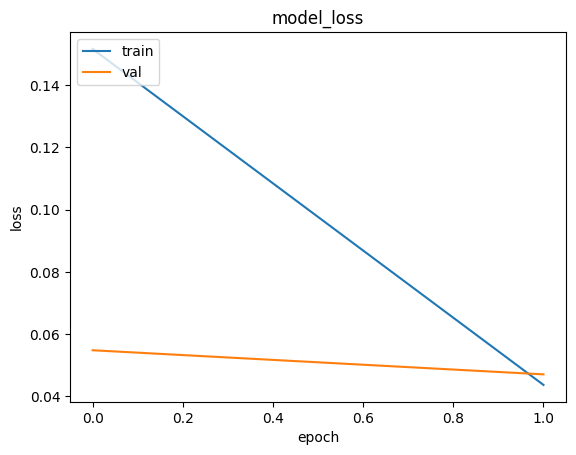

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [52]:
metric=evaluate.load("seqeval")

In [53]:
ind_to_label={0:'O', 1:'B-PER',2:'I-PER',3:'B-ORG',4:'I-ORG',5:'B-LOC',6:'I-LOC',7:'B-MISC',8:'I-MISC'}
all_predictions = []
all_labels = []

In [ ]:
for batch in tf_val_dataset:
  logits = model.predict(batch)["logits"]
  labels = batch["labels"].numpy()
  predictions = tf.argmax(logits, axis=-1).numpy()
  #print(labels)
  #print(predictions)
  for prediction, label in zip(predictions, labels):
    for predicted_idx, label_idx in zip(prediction, label):
      if label_idx == -100:
          continue
      all_predictions.append(ind_to_label[predicted_idx])
      all_labels.append(ind_to_label[label_idx])

In [55]:
metric.compute(predictions=[all_predictions], references=[all_labels])


{'LOC': {'precision': 0.9582887700534759,
  'recall': 0.9755035383777899,
  'f1': 0.9668195306177502,
  'number': 1837},
 'MISC': {'precision': 0.8393039918116684,
  'recall': 0.8893709327548807,
  'f1': 0.8636124275934703,
  'number': 922},
 'ORG': {'precision': 0.9172821270310192,
  'recall': 0.9261744966442953,
  'f1': 0.9217068645640074,
  'number': 1341},
 'PER': {'precision': 0.9736133548734518,
  'recall': 0.9815418023887079,
  'f1': 0.9775615031089484,
  'number': 1842},
 'overall_precision': 0.9346318917134367,
 'overall_recall': 0.9528778189161898,
 'overall_f1': 0.9436666666666667,
 'overall_accuracy': 0.9875118897855236}

# 10. Testing

In [ ]:
inputs=tokenizer(["Wake Up JoeMarshal, you just got a call from UNESCO for a trip to India"], padding=True,return_tensors="tf")


In [ ]:
print(inputs.tokens())
print(inputs.word_ids())
print(inputs['input_ids'])

# 11. Saving the model

In [56]:
model.save('/content/drive/MyDrive/nlp/Named Entity Relation')